## Setup

In [1]:
%load_ext autoreload
%autoreload 3
import sys

sys.path.append("..")

In [2]:
from nnsight.models.UnifiedTransformer import UnifiedTransformer
import torch.nn.functional as F
import torch as th
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from transformers import AutoTokenizer
from pathlib import Path
from time import time
import itertools
th.set_grad_enabled(False)

In [3]:
model = "croissantllm/CroissantLLMBase"
check_translation_performance = False
batch_size = 8
thinking_langs = ["en", "fr"]
langs = ["en", "fr", "de", "ru", "zh"]

In [4]:
BATCH_SIZE = batch_size
del batch_size
langs = np.array(langs)
from utils import add_model_to_transformer_lens
add_model_to_transformer_lens(model)
extra_langs = [lang for lang in langs if lang not in thinking_langs]
out_langs = {lang: np.array([l for l in extra_langs if l != lang]) for lang in langs}
# tokenizer = AutoTokenizer.from_pretrained(model, padding_side="left")
# tokenizer.pad_token_id = tokenizer.eos_token_id
nn_model = UnifiedTransformer(model, device="auto", processing=False) # , tokenizer=tokenizer)
# tokenizer = nn_model.tokenizer

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model croissantllm/CroissantLLMBase into HookedTransformer


## Translation accuracy

In [6]:
if check_translation_performance:
    from exp_tools import get_translations, translation_prompts, logit_lens
    accuracies = np.ones((len(langs), len(langs)))
    translation_accuracies = {(lang, l) : 1 for lang, l in itertools.product(langs, langs)}
    probs = np.ones((len(langs), len(langs)))
    df = get_translations(langs)
    for i, input_lang in enumerate(langs):
        for j, output_lang in enumerate(langs):
            if input_lang == output_lang:
                continue
            prompts = translation_prompts(
                df, tokenizer, input_lang, output_lang, output_lang
            )
            success = 0
            str_prompts = [p.prompt for p in prompts]
            with th.no_grad():
                with nn_model.generate(
                    str_prompts,
                    max_new_tokens=1,
                    pad_token_id=tokenizer.eos_token_id,
                    do_sample=False,
                ) as tracer:
                    output = nn_model.generator.output.save()
            for ip, p in enumerate(prompts):
                if output[ip][-1].item() in p.target_tokens:
                    success += 1
            accuracies[i, j] = success / len(prompts)
            translation_accuracies[(input_lang, output_lang)] = accuracies[i, j]
            llens = logit_lens(nn_model, str_prompts)
            cum_probs = 0
            for ip, p in enumerate(prompts):
                cum_probs[i, j] += llens[ip, -1, p.target_tokens].sum()
            probs[i, j] = cum_probs / len(prompts)
            print(
                f"Accuracy {input_lang} -> {output_lang}:\nAcc: {accuracies[i, j]}\nProb: {probs[i, j]}"
            )

    sns.heatmap(
        accuracies, annot=True, cmap="YlGnBu", xticklabels=langs, yticklabels=langs
    )
    plt.title("Translation Accuracies")
    plt.xlabel("Output Language")
    plt.ylabel("Input Language")
    plt.show()
    sns.heatmap(probs, annot=True, cmap="YlGnBu", xticklabels=langs, yticklabels=langs)
    plt.title("Translation Mean Probabilities")
    plt.xlabel("Output Language")
    plt.ylabel("Input Language")
    plt.show()
    mean_accuracies = accuracies.mean(axis=1)
    sorted_indices = np.argsort(mean_accuracies)[::-1]
    langs = langs[sorted_indices]
    extra_langs = [lang for lang in langs if lang not in thinking_langs]
    for lang in langs:
        out_langs[lang] = sorted(out_langs[lang], key=lambda l: translation_accuracies[(lang, l)], reverse=True)


## Logit Lens plots

Found 104 translations


  0%|          | 0/13 [00:00<?, ?it/s]

2024-04-17 16:44:14,921 [nnsight] INFO: Running `HookedTransformer`...
2024-04-17 16:44:14,923 [nnsight] INFO: => SET(argument_0)
2024-04-17 16:44:14,924 [nnsight] INFO: => DEL(argument_0)
2024-04-17 16:44:14,945 [nnsight] INFO: => SET(argument_1)
2024-04-17 16:44:14,946 [nnsight] INFO: => SET(getitem_0)
2024-04-17 16:44:14,972 [nnsight] INFO: => SET(fetch_attr_0)
2024-04-17 16:44:14,979 [nnsight] INFO: => SET(proxy_call_0)
2024-04-17 16:44:14,980 [nnsight] INFO: => DEL(fetch_attr_0)
2024-04-17 16:44:14,982 [nnsight] INFO: => DEL(getitem_0)
2024-04-17 16:44:14,983 [nnsight] INFO: => DEL(argument_1)
2024-04-17 16:44:14,989 [nnsight] INFO: => SET(argument_2)
2024-04-17 16:44:15,000 [nnsight] INFO: => SET(getitem_1)
2024-04-17 16:44:15,002 [nnsight] INFO: => SET(fetch_attr_1)
2024-04-17 16:44:15,003 [nnsight] INFO: => SET(proxy_call_1)
2024-04-17 16:44:15,004 [nnsight] INFO: => DEL(fetch_attr_1)
2024-04-17 16:44:15,005 [nnsight] INFO: => DEL(getitem_1)
2024-04-17 16:44:15,006 [nnsight] IN

torch.Size([192, 3, 32000]) torch.Size([192, 3, 32000]) torch.Size([192, 3, 2048]) torch.Size([8, 2048])


2024-04-17 16:44:32,391 [nnsight] INFO: Running `HookedTransformer`...
2024-04-17 16:44:32,392 [nnsight] INFO: => SET(argument_0)
2024-04-17 16:44:32,393 [nnsight] INFO: => DEL(argument_0)
2024-04-17 16:44:32,425 [nnsight] INFO: => SET(argument_1)
2024-04-17 16:44:32,428 [nnsight] INFO: => SET(getitem_0)
2024-04-17 16:44:32,429 [nnsight] INFO: => SET(fetch_attr_0)
2024-04-17 16:44:32,429 [nnsight] INFO: => SET(proxy_call_0)
2024-04-17 16:44:32,431 [nnsight] INFO: => DEL(fetch_attr_0)
2024-04-17 16:44:32,432 [nnsight] INFO: => DEL(getitem_0)
2024-04-17 16:44:32,433 [nnsight] INFO: => DEL(argument_1)
2024-04-17 16:44:32,451 [nnsight] INFO: => SET(argument_2)
2024-04-17 16:44:32,454 [nnsight] INFO: => SET(getitem_1)
2024-04-17 16:44:32,457 [nnsight] INFO: => SET(fetch_attr_1)
2024-04-17 16:44:32,459 [nnsight] INFO: => SET(proxy_call_1)
2024-04-17 16:44:32,460 [nnsight] INFO: => DEL(fetch_attr_1)
2024-04-17 16:44:32,462 [nnsight] INFO: => DEL(getitem_1)
2024-04-17 16:44:32,463 [nnsight] IN

torch.Size([192, 3, 32000]) torch.Size([192, 3, 32000]) torch.Size([192, 3, 2048]) torch.Size([8, 2048])


2024-04-17 16:44:40,457 [nnsight] INFO: Running `HookedTransformer`...
2024-04-17 16:44:40,458 [nnsight] INFO: => SET(argument_0)
2024-04-17 16:44:40,459 [nnsight] INFO: => DEL(argument_0)
2024-04-17 16:44:40,469 [nnsight] INFO: => SET(argument_1)
2024-04-17 16:44:40,470 [nnsight] INFO: => SET(getitem_0)
2024-04-17 16:44:40,471 [nnsight] INFO: => SET(fetch_attr_0)
2024-04-17 16:44:40,471 [nnsight] INFO: => SET(proxy_call_0)
2024-04-17 16:44:40,472 [nnsight] INFO: => DEL(fetch_attr_0)
2024-04-17 16:44:40,473 [nnsight] INFO: => DEL(getitem_0)
2024-04-17 16:44:40,473 [nnsight] INFO: => DEL(argument_1)
2024-04-17 16:44:40,477 [nnsight] INFO: => SET(argument_2)
2024-04-17 16:44:40,478 [nnsight] INFO: => SET(getitem_1)
2024-04-17 16:44:40,479 [nnsight] INFO: => SET(fetch_attr_1)
2024-04-17 16:44:40,480 [nnsight] INFO: => SET(proxy_call_1)
2024-04-17 16:44:40,481 [nnsight] INFO: => DEL(fetch_attr_1)
2024-04-17 16:44:40,481 [nnsight] INFO: => DEL(getitem_1)
2024-04-17 16:44:40,482 [nnsight] IN

torch.Size([192, 3, 32000]) torch.Size([192, 3, 32000]) torch.Size([192, 3, 2048]) torch.Size([8, 2048])


2024-04-17 16:44:48,410 [nnsight] INFO: => DEL(argument_0)
2024-04-17 16:44:48,422 [nnsight] INFO: => SET(argument_1)
2024-04-17 16:44:48,425 [nnsight] INFO: => SET(getitem_0)
2024-04-17 16:44:48,427 [nnsight] INFO: => SET(fetch_attr_0)
2024-04-17 16:44:48,429 [nnsight] INFO: => SET(proxy_call_0)
2024-04-17 16:44:48,430 [nnsight] INFO: => DEL(fetch_attr_0)
2024-04-17 16:44:48,431 [nnsight] INFO: => DEL(getitem_0)
2024-04-17 16:44:48,432 [nnsight] INFO: => DEL(argument_1)
2024-04-17 16:44:48,437 [nnsight] INFO: => SET(argument_2)
2024-04-17 16:44:48,440 [nnsight] INFO: => SET(getitem_1)
2024-04-17 16:44:48,441 [nnsight] INFO: => SET(fetch_attr_1)
2024-04-17 16:44:48,443 [nnsight] INFO: => SET(proxy_call_1)
2024-04-17 16:44:48,445 [nnsight] INFO: => DEL(fetch_attr_1)
2024-04-17 16:44:48,446 [nnsight] INFO: => DEL(getitem_1)
2024-04-17 16:44:48,448 [nnsight] INFO: => DEL(argument_2)
2024-04-17 16:44:48,454 [nnsight] INFO: => SET(argument_3)
2024-04-17 16:44:48,455 [nnsight] INFO: => SET(g

torch.Size([192, 3, 32000]) torch.Size([192, 3, 32000]) torch.Size([192, 3, 2048]) torch.Size([8, 2048])


2024-04-17 16:44:57,774 [nnsight] INFO: Running `HookedTransformer`...
2024-04-17 16:44:57,779 [nnsight] INFO: => SET(argument_0)
2024-04-17 16:44:57,783 [nnsight] INFO: => DEL(argument_0)
2024-04-17 16:44:57,803 [nnsight] INFO: => SET(argument_1)
2024-04-17 16:44:57,809 [nnsight] INFO: => SET(getitem_0)
2024-04-17 16:44:57,816 [nnsight] INFO: => SET(fetch_attr_0)
2024-04-17 16:44:57,820 [nnsight] INFO: => SET(proxy_call_0)
2024-04-17 16:44:57,823 [nnsight] INFO: => DEL(fetch_attr_0)
2024-04-17 16:44:57,826 [nnsight] INFO: => DEL(getitem_0)
2024-04-17 16:44:57,829 [nnsight] INFO: => DEL(argument_1)
2024-04-17 16:44:57,840 [nnsight] INFO: => SET(argument_2)
2024-04-17 16:44:57,848 [nnsight] INFO: => SET(getitem_1)
2024-04-17 16:44:57,855 [nnsight] INFO: => SET(fetch_attr_1)
2024-04-17 16:44:57,862 [nnsight] INFO: => SET(proxy_call_1)
2024-04-17 16:44:57,868 [nnsight] INFO: => DEL(fetch_attr_1)
2024-04-17 16:44:57,872 [nnsight] INFO: => DEL(getitem_1)
2024-04-17 16:44:57,874 [nnsight] IN

torch.Size([192, 3, 32000]) torch.Size([192, 3, 32000]) torch.Size([192, 3, 2048]) torch.Size([8, 2048])


2024-04-17 16:45:04,062 [nnsight] INFO: Running `HookedTransformer`...
2024-04-17 16:45:04,064 [nnsight] INFO: => SET(argument_0)
2024-04-17 16:45:04,066 [nnsight] INFO: => DEL(argument_0)
2024-04-17 16:45:04,081 [nnsight] INFO: => SET(argument_1)
2024-04-17 16:45:04,083 [nnsight] INFO: => SET(getitem_0)
2024-04-17 16:45:04,084 [nnsight] INFO: => SET(fetch_attr_0)
2024-04-17 16:45:04,084 [nnsight] INFO: => SET(proxy_call_0)
2024-04-17 16:45:04,085 [nnsight] INFO: => DEL(fetch_attr_0)
2024-04-17 16:45:04,086 [nnsight] INFO: => DEL(getitem_0)
2024-04-17 16:45:04,087 [nnsight] INFO: => DEL(argument_1)
2024-04-17 16:45:04,092 [nnsight] INFO: => SET(argument_2)
2024-04-17 16:45:04,093 [nnsight] INFO: => SET(getitem_1)
2024-04-17 16:45:04,094 [nnsight] INFO: => SET(fetch_attr_1)
2024-04-17 16:45:04,094 [nnsight] INFO: => SET(proxy_call_1)
2024-04-17 16:45:04,095 [nnsight] INFO: => DEL(fetch_attr_1)
2024-04-17 16:45:04,096 [nnsight] INFO: => DEL(getitem_1)
2024-04-17 16:45:04,096 [nnsight] IN

torch.Size([192, 3, 32000]) torch.Size([192, 3, 32000]) torch.Size([192, 3, 2048]) torch.Size([8, 2048])


2024-04-17 16:45:12,511 [nnsight] INFO: Running `HookedTransformer`...
2024-04-17 16:45:12,528 [nnsight] INFO: => SET(argument_0)
2024-04-17 16:45:12,529 [nnsight] INFO: => DEL(argument_0)
2024-04-17 16:45:12,562 [nnsight] INFO: => SET(argument_1)
2024-04-17 16:45:12,564 [nnsight] INFO: => SET(getitem_0)
2024-04-17 16:45:12,564 [nnsight] INFO: => SET(fetch_attr_0)
2024-04-17 16:45:12,570 [nnsight] INFO: => SET(proxy_call_0)
2024-04-17 16:45:12,572 [nnsight] INFO: => DEL(fetch_attr_0)
2024-04-17 16:45:12,577 [nnsight] INFO: => DEL(getitem_0)
2024-04-17 16:45:12,581 [nnsight] INFO: => DEL(argument_1)
2024-04-17 16:45:12,584 [nnsight] INFO: => SET(argument_2)
2024-04-17 16:45:12,585 [nnsight] INFO: => SET(getitem_1)
2024-04-17 16:45:12,586 [nnsight] INFO: => SET(fetch_attr_1)
2024-04-17 16:45:12,594 [nnsight] INFO: => SET(proxy_call_1)
2024-04-17 16:45:12,594 [nnsight] INFO: => DEL(fetch_attr_1)
2024-04-17 16:45:12,595 [nnsight] INFO: => DEL(getitem_1)
2024-04-17 16:45:12,596 [nnsight] IN

torch.Size([192, 3, 32000]) torch.Size([192, 3, 32000]) torch.Size([192, 3, 2048]) torch.Size([8, 2048])


2024-04-17 16:45:21,960 [nnsight] INFO: Running `HookedTransformer`...
2024-04-17 16:45:21,973 [nnsight] INFO: => SET(argument_0)
2024-04-17 16:45:21,974 [nnsight] INFO: => DEL(argument_0)
2024-04-17 16:45:21,982 [nnsight] INFO: => SET(argument_1)
2024-04-17 16:45:21,983 [nnsight] INFO: => SET(getitem_0)
2024-04-17 16:45:21,983 [nnsight] INFO: => SET(fetch_attr_0)
2024-04-17 16:45:21,984 [nnsight] INFO: => SET(proxy_call_0)
2024-04-17 16:45:21,992 [nnsight] INFO: => DEL(fetch_attr_0)
2024-04-17 16:45:21,993 [nnsight] INFO: => DEL(getitem_0)
2024-04-17 16:45:21,994 [nnsight] INFO: => DEL(argument_1)
2024-04-17 16:45:21,997 [nnsight] INFO: => SET(argument_2)
2024-04-17 16:45:21,998 [nnsight] INFO: => SET(getitem_1)
2024-04-17 16:45:21,998 [nnsight] INFO: => SET(fetch_attr_1)
2024-04-17 16:45:21,999 [nnsight] INFO: => SET(proxy_call_1)
2024-04-17 16:45:21,999 [nnsight] INFO: => DEL(fetch_attr_1)
2024-04-17 16:45:22,000 [nnsight] INFO: => DEL(getitem_1)
2024-04-17 16:45:22,000 [nnsight] IN

torch.Size([192, 3, 32000]) torch.Size([192, 3, 32000]) torch.Size([192, 3, 2048]) torch.Size([8, 2048])


2024-04-17 16:45:30,641 [nnsight] INFO: Running `HookedTransformer`...
2024-04-17 16:45:30,642 [nnsight] INFO: => SET(argument_0)
2024-04-17 16:45:30,643 [nnsight] INFO: => DEL(argument_0)
2024-04-17 16:45:30,653 [nnsight] INFO: => SET(argument_1)
2024-04-17 16:45:30,654 [nnsight] INFO: => SET(getitem_0)
2024-04-17 16:45:30,654 [nnsight] INFO: => SET(fetch_attr_0)
2024-04-17 16:45:30,655 [nnsight] INFO: => SET(proxy_call_0)
2024-04-17 16:45:30,655 [nnsight] INFO: => DEL(fetch_attr_0)
2024-04-17 16:45:30,656 [nnsight] INFO: => DEL(getitem_0)
2024-04-17 16:45:30,656 [nnsight] INFO: => DEL(argument_1)
2024-04-17 16:45:30,661 [nnsight] INFO: => SET(argument_2)
2024-04-17 16:45:30,662 [nnsight] INFO: => SET(getitem_1)
2024-04-17 16:45:30,668 [nnsight] INFO: => SET(fetch_attr_1)
2024-04-17 16:45:30,670 [nnsight] INFO: => SET(proxy_call_1)
2024-04-17 16:45:30,670 [nnsight] INFO: => DEL(fetch_attr_1)
2024-04-17 16:45:30,671 [nnsight] INFO: => DEL(getitem_1)
2024-04-17 16:45:30,672 [nnsight] IN

torch.Size([192, 3, 32000]) torch.Size([192, 3, 32000]) torch.Size([192, 3, 2048]) torch.Size([8, 2048])


2024-04-17 16:45:37,647 [nnsight] INFO: Running `HookedTransformer`...
2024-04-17 16:45:37,673 [nnsight] INFO: => SET(argument_0)
2024-04-17 16:45:37,676 [nnsight] INFO: => DEL(argument_0)
2024-04-17 16:45:37,770 [nnsight] INFO: => SET(argument_1)
2024-04-17 16:45:37,774 [nnsight] INFO: => SET(getitem_0)
2024-04-17 16:45:37,775 [nnsight] INFO: => SET(fetch_attr_0)
2024-04-17 16:45:37,776 [nnsight] INFO: => SET(proxy_call_0)
2024-04-17 16:45:37,777 [nnsight] INFO: => DEL(fetch_attr_0)
2024-04-17 16:45:37,779 [nnsight] INFO: => DEL(getitem_0)
2024-04-17 16:45:37,780 [nnsight] INFO: => DEL(argument_1)
2024-04-17 16:45:37,787 [nnsight] INFO: => SET(argument_2)
2024-04-17 16:45:37,804 [nnsight] INFO: => SET(getitem_1)
2024-04-17 16:45:37,805 [nnsight] INFO: => SET(fetch_attr_1)
2024-04-17 16:45:37,806 [nnsight] INFO: => SET(proxy_call_1)
2024-04-17 16:45:37,807 [nnsight] INFO: => DEL(fetch_attr_1)
2024-04-17 16:45:37,808 [nnsight] INFO: => DEL(getitem_1)
2024-04-17 16:45:37,809 [nnsight] IN

torch.Size([192, 3, 32000]) torch.Size([192, 3, 32000]) torch.Size([192, 3, 2048]) torch.Size([8, 2048])


2024-04-17 16:45:45,842 [nnsight] INFO: => DEL(argument_6)
2024-04-17 16:45:45,846 [nnsight] INFO: => SET(argument_7)
2024-04-17 16:45:45,846 [nnsight] INFO: => SET(getitem_6)
2024-04-17 16:45:45,847 [nnsight] INFO: => SET(fetch_attr_6)
2024-04-17 16:45:45,848 [nnsight] INFO: => SET(proxy_call_6)
2024-04-17 16:45:45,848 [nnsight] INFO: => DEL(fetch_attr_6)
2024-04-17 16:45:45,849 [nnsight] INFO: => DEL(getitem_6)
2024-04-17 16:45:45,850 [nnsight] INFO: => DEL(argument_7)
2024-04-17 16:45:45,853 [nnsight] INFO: => SET(argument_8)
2024-04-17 16:45:45,854 [nnsight] INFO: => SET(getitem_7)
2024-04-17 16:45:45,855 [nnsight] INFO: => SET(fetch_attr_7)
2024-04-17 16:45:45,855 [nnsight] INFO: => SET(proxy_call_7)
2024-04-17 16:45:45,856 [nnsight] INFO: => DEL(fetch_attr_7)
2024-04-17 16:45:45,857 [nnsight] INFO: => DEL(getitem_7)
2024-04-17 16:45:45,857 [nnsight] INFO: => DEL(argument_8)
2024-04-17 16:45:45,861 [nnsight] INFO: => SET(argument_9)
2024-04-17 16:45:45,862 [nnsight] INFO: => SET(g

torch.Size([192, 3, 32000]) torch.Size([192, 3, 32000]) torch.Size([192, 3, 2048]) torch.Size([8, 2048])


2024-04-17 16:45:53,005 [nnsight] INFO: Running `HookedTransformer`...
2024-04-17 16:45:53,007 [nnsight] INFO: => SET(argument_0)
2024-04-17 16:45:53,008 [nnsight] INFO: => DEL(argument_0)
2024-04-17 16:45:53,026 [nnsight] INFO: => SET(argument_1)
2024-04-17 16:45:53,028 [nnsight] INFO: => SET(getitem_0)
2024-04-17 16:45:53,028 [nnsight] INFO: => SET(fetch_attr_0)
2024-04-17 16:45:53,029 [nnsight] INFO: => SET(proxy_call_0)
2024-04-17 16:45:53,030 [nnsight] INFO: => DEL(fetch_attr_0)
2024-04-17 16:45:53,031 [nnsight] INFO: => DEL(getitem_0)
2024-04-17 16:45:53,031 [nnsight] INFO: => DEL(argument_1)
2024-04-17 16:45:53,045 [nnsight] INFO: => SET(argument_2)
2024-04-17 16:45:53,047 [nnsight] INFO: => SET(getitem_1)
2024-04-17 16:45:53,048 [nnsight] INFO: => SET(fetch_attr_1)
2024-04-17 16:45:53,048 [nnsight] INFO: => SET(proxy_call_1)
2024-04-17 16:45:53,049 [nnsight] INFO: => DEL(fetch_attr_1)
2024-04-17 16:45:53,049 [nnsight] INFO: => DEL(getitem_1)
2024-04-17 16:45:53,050 [nnsight] IN

torch.Size([192, 3, 32000]) torch.Size([192, 3, 32000]) torch.Size([192, 3, 2048]) torch.Size([8, 2048])


2024-04-17 16:45:59,319 [nnsight] INFO: Running `HookedTransformer`...
2024-04-17 16:45:59,325 [nnsight] INFO: => SET(argument_0)
2024-04-17 16:45:59,326 [nnsight] INFO: => DEL(argument_0)
2024-04-17 16:45:59,347 [nnsight] INFO: => SET(argument_1)
2024-04-17 16:45:59,348 [nnsight] INFO: => SET(getitem_0)
2024-04-17 16:45:59,349 [nnsight] INFO: => SET(fetch_attr_0)
2024-04-17 16:45:59,349 [nnsight] INFO: => SET(proxy_call_0)
2024-04-17 16:45:59,350 [nnsight] INFO: => DEL(fetch_attr_0)
2024-04-17 16:45:59,351 [nnsight] INFO: => DEL(getitem_0)
2024-04-17 16:45:59,352 [nnsight] INFO: => DEL(argument_1)
2024-04-17 16:45:59,357 [nnsight] INFO: => SET(argument_2)
2024-04-17 16:45:59,358 [nnsight] INFO: => SET(getitem_1)
2024-04-17 16:45:59,359 [nnsight] INFO: => SET(fetch_attr_1)
2024-04-17 16:45:59,360 [nnsight] INFO: => SET(proxy_call_1)
2024-04-17 16:45:59,361 [nnsight] INFO: => DEL(fetch_attr_1)
2024-04-17 16:45:59,362 [nnsight] INFO: => DEL(getitem_1)
2024-04-17 16:45:59,362 [nnsight] IN

torch.Size([192, 3, 32000]) torch.Size([192, 3, 32000]) torch.Size([192, 3, 2048]) torch.Size([8, 2048])


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Translation from es to de'}>)

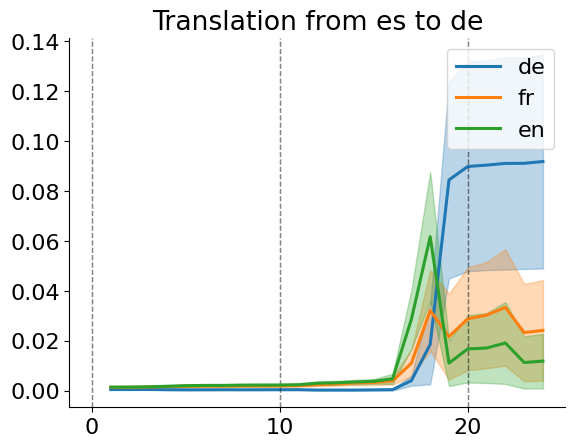

In [17]:
from exp_tools import run_prompts
from translation_tools import translation_prompts
from translation_tools import get_gpt4_dataset as get_translations
from utils import plot_ci
from cache_decorator import Cache
@Cache(cache_path="{cache_dir}/cached_prompt23/{_hash}.pkl", cache_dir="/tmp", args_to_ignore=["tokenizer"])
def cached_translation_prompt(df, tokenizer, input_lang, target_lang, latent_langs):
    return translation_prompts(df, tokenizer, input_lang, target_lang, latent_langs)

def translation_plot(input_lang, target_lang, latent_langs, batch_size=BATCH_SIZE, method="logit_lens", num_words=25, use_cache=False):
    if isinstance(latent_langs, str):
        latent_langs = [latent_langs]
    df = get_translations(input_lang, [target_lang] + latent_langs, num_words=num_words)
    if use_cache:
        prompts = cached_translation_prompt(
            df, nn_model.tokenizer, input_lang, target_lang, latent_langs
        )
    else:
        prompts = translation_prompts(
            df, nn_model.tokenizer, input_lang, target_lang, latent_langs
        )
    target_probs, latent_probs = run_prompts(nn_model, prompts, batch_size=batch_size, method=method)
    json_dic = {target_lang: target_probs.tolist()}
    for lang, probs in latent_probs.items():
        json_dic[lang] = probs.tolist()
    path = Path("results") / "translation"
    path.mkdir(parents=True, exist_ok=True)
    json_file = path / (
        "_".join([input_lang, target_lang, *latent_langs, str(int(time()))]) + ".json"
    )
    with open(json_file, "w") as f:
        json.dump(json_dic, f, indent=4)
    fig, ax = plt.subplots()
    colors = sns.color_palette("tab10", len(latent_langs) + 1)
    plot_ci(ax, target_probs, label=target_lang, color=colors[0])
    colors = {lang: color for lang, color in zip(latent_langs, colors[1:])}
    for latent_lang, probs in latent_probs.items():
        plot_ci(ax, probs, label=latent_lang, color=colors[latent_lang])
    ax.legend()
    ax.set_title(f"Translation from {input_lang} to {target_lang}")
    return fig, ax
translation_plot("es", "de", ["fr", "en"], num_words=None, method="patchscope", use_cache=True)

Found 104 translations


  0%|          | 0/13 [00:00<?, ?it/s]

2024-04-17 16:46:50,440 [nnsight] INFO: Running `HookedTransformer`...
2024-04-17 16:46:50,441 [nnsight] INFO: => SET(argument_0)
2024-04-17 16:46:50,442 [nnsight] INFO: => SET(fetch_attr_24)
2024-04-17 16:46:50,442 [nnsight] INFO: => SET(fetch_attr_25)
2024-04-17 16:46:50,443 [nnsight] INFO: => DEL(fetch_attr_24)
2024-04-17 16:46:50,444 [nnsight] INFO: => SET(fetch_attr_26)
2024-04-17 16:46:50,445 [nnsight] INFO: => SET(fetch_attr_27)
2024-04-17 16:46:50,445 [nnsight] INFO: => DEL(fetch_attr_26)
2024-04-17 16:46:50,446 [nnsight] INFO: => DEL(argument_0)
2024-04-17 16:46:50,476 [nnsight] INFO: => SET(argument_1)
2024-04-17 16:46:50,478 [nnsight] INFO: => SET(getitem_0)
2024-04-17 16:46:50,480 [nnsight] INFO: => SET(fetch_attr_0)
2024-04-17 16:46:50,482 [nnsight] INFO: => SET(proxy_call_0)
2024-04-17 16:46:50,494 [nnsight] INFO: => DEL(fetch_attr_0)
2024-04-17 16:46:50,495 [nnsight] INFO: => DEL(getitem_0)
2024-04-17 16:46:50,496 [nnsight] INFO: => DEL(argument_1)
2024-04-17 16:46:50,51

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Translation from es to de'}>)

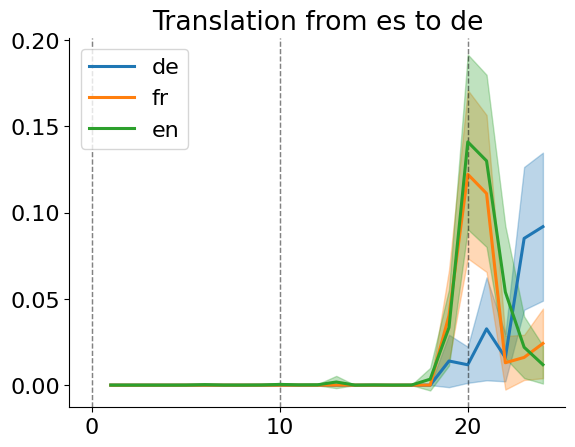

In [18]:
translation_plot("es", "de", ["fr", "en"], num_words=None, use_cache=True)

### Thinking language translation

Found 109 translations


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Found 109 translations


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Found 104 translations


  0%|          | 0/104 [00:00<?, ?it/s]

KeyboardInterrupt: 

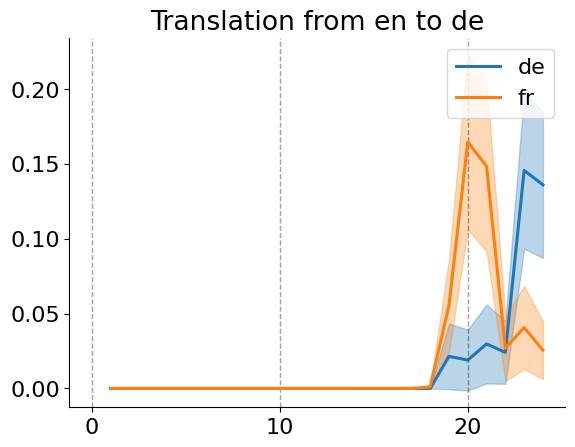

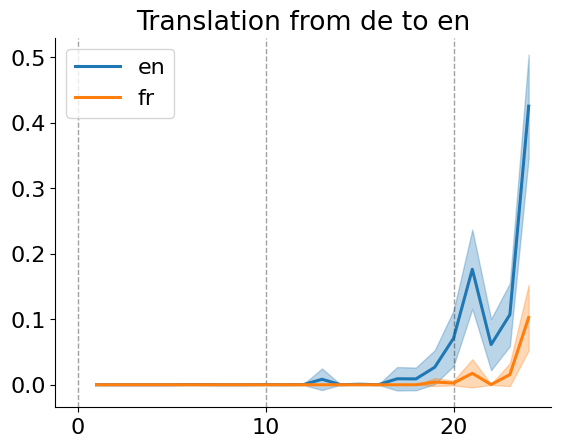

In [ ]:
for lang in thinking_langs:
    for target_l in out_langs[lang]:
        th.cuda.empty_cache()
        fig, _  = translation_plot(lang, target_l, thinking_langs)
        plt.show()
        fig, _ = translation_plot(target_l, lang, [l for l in thinking_langs if l != lang])
        plt.show()

### Other language translation

In [ ]:
for lang in extra_langs:
    for target_l in out_langs[lang]:
        th.cuda.empty_cache()
        fig, _  = translation_plot(lang, target_l, thinking_langs)
        fig.show()